In [1]:
import tensorflow as tf
from tensorflow.keras import __version__ as keras_version
tf.random.set_seed(21)
print("TF version: {}\nKeras version: {}".format(tf.__version__, keras_version))

TF version: 2.3.2
Keras version: 2.4.0


In [3]:
# Import statements

import csv
# import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Flatten, Dense, Conv2D, Dropout, MaxPool2D, \
                                    Lambda, Cropping2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.metrics import mape, mae
from sklearn.model_selection import train_test_split
# List GPU devices accessible to Docker container
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) # list of DeviceAttributes


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14121199078989966594
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6270895640743805738
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8427645445581136941
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5811952704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2643119847844973285
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
def parse_data_log(log_path, has_header):
    lines = []
    with open(log_path) as logfile:
        reader = csv.reader(logfile)
        if has_header:
            next(reader, None)
        for line in reader:
            lines.append(line)
    return lines

# Loading data from two sources - 
# Directory 'data/driving_log.csv' contains the data collected manually for 2 laps of the track - 1 CW, 1 CCW
# Directory 'data_old/data/driving_log.csv' contains the data provided as part of the Project repo
lines = parse_data_log('data/driving_log.csv', False)
log_new_df = pd.DataFrame(data=lines, columns=['center', 'left', 'right', 'angle', 'throttle', 'break', 'speed'])
log_new_df['center'] = log_new_df['center'].apply(lambda x : '/'.join(x.split('/')[-3:]))
log_new_df['left'] = log_new_df['left'].apply(lambda x : '/'.join(x.split('/')[-3:]))
log_new_df['right'] = log_new_df['right'].apply(lambda x : '/'.join(x.split('/')[-3:]))
log_new_df['angle'] = log_new_df['angle'].apply(lambda x : round(float(x), 3))
lines_old = parse_data_log('data_old/data/driving_log.csv', True)
log_old_df = pd.DataFrame(data=lines_old, columns=['center', 'left', 'right', 'angle', 'throttle', 'break', 'speed'])
log_old_df['center'] = log_old_df['center'].apply(lambda x : '/'.join(['data_old/data', x.strip()]))
log_old_df['left'] = log_old_df['left'].apply(lambda x : '/'.join(['data_old/data', x.strip()]))
log_old_df['right'] = log_old_df['right'].apply(lambda x : '/'.join(['data_old/data', x.strip()]))
log_old_df['angle'] = log_old_df['angle'].apply(lambda x : round(float(x), 3))
log_df = log_new_df.append(log_old_df, ignore_index=True)
print(log_new_df.shape, log_old_df.shape, log_df.shape)
log_df.head()

(2098, 7) (8036, 7) (10134, 7)


,center,left,right,angle,throttle,break,speed
0,data/IMG/center_2021_03_11_19_40_04_610.jpg,data/IMG/left_2021_03_11_19_40_04_610.jpg,data/IMG/right_2021_03_11_19_40_04_610.jpg,0.0,0,0,7.756447E-06
1,data/IMG/center_2021_03_11_19_40_04_689.jpg,data/IMG/left_2021_03_11_19_40_04_689.jpg,data/IMG/right_2021_03_11_19_40_04_689.jpg,0.0,0,0,9.216844E-06
2,data/IMG/center_2021_03_11_19_40_04_770.jpg,data/IMG/left_2021_03_11_19_40_04_770.jpg,data/IMG/right_2021_03_11_19_40_04_770.jpg,0.0,0,0,2.261843E-05
3,data/IMG/center_2021_03_11_19_40_04_852.jpg,data/IMG/left_2021_03_11_19_40_04_852.jpg,data/IMG/right_2021_03_11_19_40_04_852.jpg,0.0,0,0,7.086373E-06
4,data/IMG/center_2021_03_11_19_40_04_940.jpg,data/IMG/left_2021_03_11_19_40_04_940.jpg,data/IMG/right_2021_03_11_19_40_04_940.jpg,0.0,0,0,6.623685E-06


In [5]:
# Splitting into train & validation set - 80-20 split
X_train, X_val, y_train, y_val = train_test_split(log_df['center'], log_df['angle'], test_size=0.2, random_state = 21) 
train_df = pd.DataFrame({'image': X_train.values, 
                         'label': y_train.values})
val_df = pd.DataFrame({'image': X_val.values, 
                       'label': y_val.values})

# Correction parameter for left & right cameras
correction = 0.2
train_left_images = log_df.iloc[X_train.index.values, 1]
# Add the correction parameter for left camera images
train_left_labels = [train_label + correction for train_label in y_train.values]
train_right_images = log_df.iloc[X_train.index.values, 2]
# Subtract the correction parameter for right camera images
train_right_labels = [train_label - correction for train_label in y_train.values]
train_df = train_df.append(pd.DataFrame({'image': train_left_images.values, 
                                        'label': np.array(train_left_labels)}), 
                                        ignore_index=True)
train_df = train_df.append(pd.DataFrame({'image': train_right_images.values, 
                            'label': np.array(train_right_labels)}), 
                            ignore_index=True)
val_left_images = log_df.iloc[X_val.index.values, 1]
# Add the correction parameter for left camera images
val_left_labels = [val_label + correction for val_label in y_val.values]
val_right_images = log_df.iloc[X_val.index.values, 2]
# Subtract the correction parameter for right camera images
val_right_labels = [val_label - correction for val_label in y_val.values]
val_df = val_df.append(pd.DataFrame({'image': val_left_images.values, 
                        'label': np.array(val_left_labels)}), 
                        ignore_index=True)
val_df = val_df.append(pd.DataFrame({'image': val_right_images.values, 
                        'label': np.array(val_right_labels)}), 
                        ignore_index=True)

train_df.shape, val_df.shape

((24321, 2), (6081, 2))

Text(0.5, 1.0, '(160, 320, 3)')

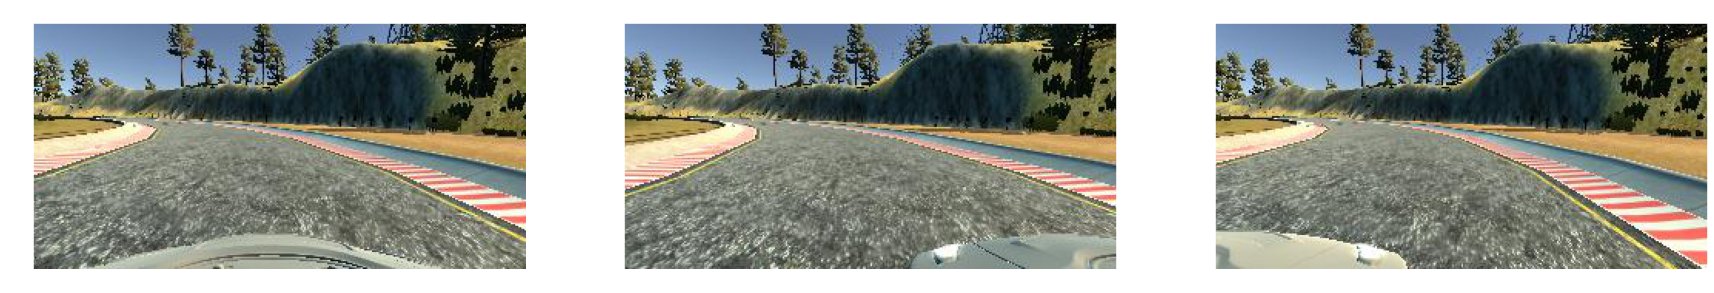

In [11]:
center_img = mpimg.imread(log_df.iloc[0][0])
left_img = mpimg.imread(log_df.iloc[0][1])
right_img = mpimg.imread(log_df.iloc[0][2])
_, axes = plt.subplots(1, 3, figsize=(30, 15))
axes[0].imshow(center_img)
axes[0].set_title(center_img.shape)
axes[1].imshow(left_img)
axes[1].set_title(left_img.shape)
axes[2].imshow(right_img)
axes[2].set_title(right_img.shape)


In [6]:
model = Sequential()
# model.add(InputLayer(input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Conv2D(kernel_size=7, filters=16, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(kernel_size=7, filters=32, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(kernel_size=5, filters=64, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(kernel_size=3, filters=128, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(kernel_size=1, filters=256, activation='relu')) # Equivalent to an FC layer.
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 84, 314, 16)       2368      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 157, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 151, 32)       25120     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 71, 64)        5

In [7]:
# Setup Hyperparams
EPOCHS = 13
BATCH_SIZE = 32

# Compile model
model.compile(optimizer=Adam(lr=0.001), 
              loss = mean_squared_error, 
              metrics = [mae])

# Prep train & val Generators with batch size = BAATCH_SIZE
img_datagen = ImageDataGenerator() # rescale=1./255
train_generator = img_datagen.flow_from_dataframe(train_df, x_col="image", y_col="label", 
                                                  target_size=(160, 320), 
                                                  class_mode="raw", 
                                                  batch_size=BATCH_SIZE, 
                                                  seed=21)
val_generator = img_datagen.flow_from_dataframe(val_df, x_col="image", y_col="label", 
                                                  target_size=(160, 320), 
                                                  class_mode="raw", 
                                                  batch_size=BATCH_SIZE, 
                                                  seed=21)

STEPS_TRAIN=train_generator.n//train_generator.batch_size
STEPS_VAL=val_generator.n//val_generator.batch_size

# Train the model
history = model.fit(train_generator, 
                    steps_per_epoch = STEPS_TRAIN, 
                    epochs = EPOCHS,
                    validation_data = val_generator, 
                    validation_steps = STEPS_VAL, 
                    workers=3, use_multiprocessing=True)

Found 24321 validated image filenames.
Found 6081 validated image filenames.
Epoch 1/13
760/760 [==============================] - 41s 54ms/step - loss: 0.0254 - mean_absolute_error: 0.1165 - val_loss: 0.0229 - val_mean_absolute_error: 0.1094
Epoch 2/13
760/760 [==============================] - 42s 55ms/step - loss: 0.0222 - mean_absolute_error: 0.1081 - val_loss: 0.0207 - val_mean_absolute_error: 0.1036
Epoch 3/13
760/760 [==============================] - 48s 63ms/step - loss: 0.0208 - mean_absolute_error: 0.1042 - val_loss: 0.0203 - val_mean_absolute_error: 0.1011
Epoch 4/13
760/760 [==============================] - 48s 63ms/step - loss: 0.0201 - mean_absolute_error: 0.1020 - val_loss: 0.0214 - val_mean_absolute_error: 0.1060
Epoch 5/13
760/760 [==============================] - 48s 63ms/step - loss: 0.0183 - mean_absolute_error: 0.0968 - val_loss: 0.0195 - val_mean_absolute_error: 0.0986
Epoch 6/13
760/760 [==============================] - 49s 64ms/step - loss: 0.0172 - mean_abs

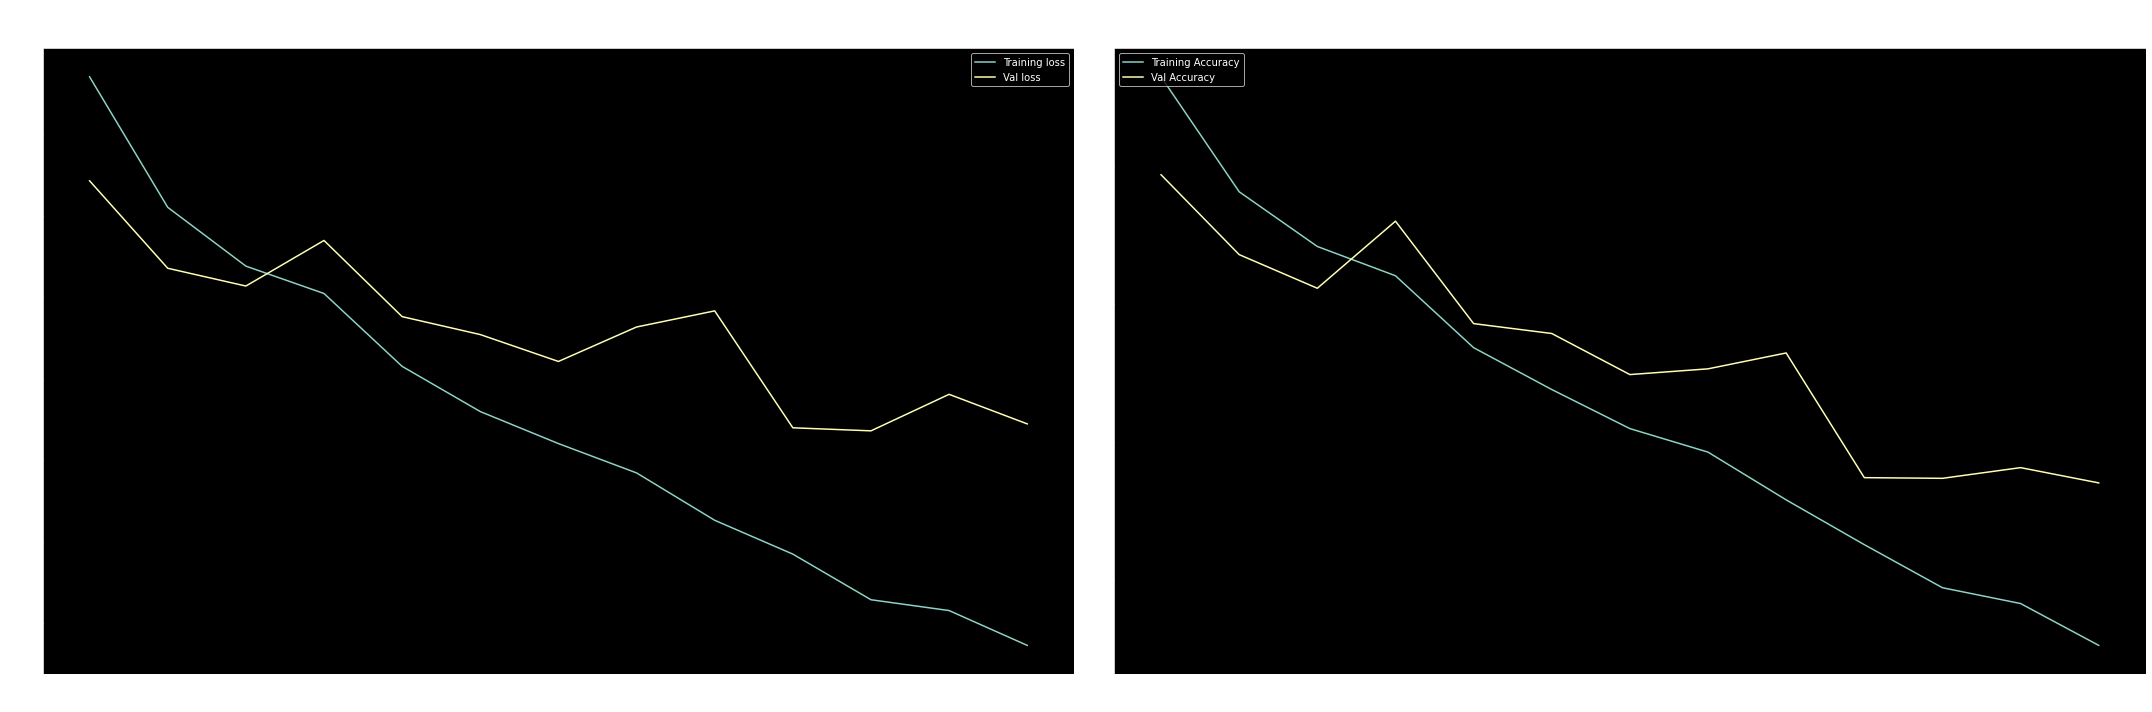

In [8]:
_, axes= plt.subplots(nrows=1, ncols=2,figsize=(30,10))
axes[0].plot(history.history['loss'], label='Training loss')
axes[0].plot(history.history['val_loss'], label='Val loss')
axes[1].plot(history.history['mean_absolute_error'], label='Training Accuracy')
axes[1].plot(history.history['val_mean_absolute_error'], label='Val Accuracy')
axes[0].set_title('Loss', size=42)
axes[1].set_title('MAE', size=42)
axes[0].legend(loc="upper right")
axes[1].legend(loc="upper left")
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [9]:
model.save('model3.h5')

Another video created using model trained for 9 epochs - output1.mp4 also looks comparable. Model3 gives little bit better performance than Model1 